In [2]:
import xarray as xr # Basic package to deal with data arrays
import xarray_sentinel # Handles most basic SAR operations
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray_sentinel/esa_safe.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [5]:
zarr_paths = sorted(glob.glob("/Users/devseed/Documents/repos/eopf-cpm/02_zarr_converted/*.zarr"))
datatrees = [xr.open_datatree(path, consolidated=True) for path in zarr_paths]
datasets = [xr.open_dataset(path, consolidated=True) for path in zarr_paths]

DATASET_NUMBER = 19

# To check for ID number of datatrees
# datatrees[1].groups
MEASUREMENTS_VH_GROUP_ID = 4
MEASUREMENTS_VV_GROUP_ID = 7
GCP_VH_GROUP_ID = 14
GCP_VV_GROUP_ID = 28
CALIBRATION_VH_GROUP_ID = 19
CALIBRATION_VV_GROUP_ID = 33

WATER_THRESHOLD_DB = -15
OTHER_THRESHOLD_DB = -20

In [6]:
type(datatrees[2]) # this product S01SIWGRD_20241031T180256_0025_A322_479F_06E71E

xarray.core.datatree.DataTree

In [7]:
datatrees[2].groups[CALIBRATION_VV_GROUP_ID] # '/S01SIWGRD_20241031T180256_0025_A322_479F_06E71E_VH/measurements'

'/S01SIWGRD_20241031T180256_0025_A322_479F_06E71E_VV/quality/calibration'

In [8]:
datatrees[2][datatrees[2].groups[MEASUREMENTS_VH_GROUP_ID]].to_dataset()

<xarray.Dataset> Size: 870MB
Dimensions:       (azimuth_time: 16677, ground_range: 26064)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 133kB 2024-10-31T18:02:56.112...
  * ground_range  (ground_range) float64 209kB 0.0 10.0 ... 2.606e+05 2.606e+05
    line          (azimuth_time) int64 133kB ...
    pixel         (ground_range) int64 209kB ...
Data variables:
    grd           (azimuth_time, ground_range) uint16 869MB ...

In [9]:
# Create measurements list 
i = 0
measurements = []
while i < DATASET_NUMBER:
    measurements.append(datatrees[i][datatrees[i].groups[MEASUREMENTS_VV_GROUP_ID]].to_dataset())
    i = i + 1

In [10]:
# Create measurements list VH
i = 0
measurementsVH = []
while i < DATASET_NUMBER:
    measurementsVH.append(datatrees[i][datatrees[i].groups[MEASUREMENTS_VH_GROUP_ID]].to_dataset())
    i = i + 1

In [11]:
# Create decimated grd list 
i = 0
grd = []
while i < DATASET_NUMBER:
    grd.append(measurements[i].grd.sel(azimuth_time=slice(None, None, 10), 
                                        ground_range=slice(None, None, 10)))
    i = i + 1

In [12]:
# Create decimated grd list VH
i = 0
grdVH = []
while i < DATASET_NUMBER:
    grdVH.append(measurementsVH[i].grd.sel(azimuth_time=slice(None, None, 20), 
                                        ground_range=slice(None, None, 20)))
    i = i + 1

In [13]:
# set(dat.ground_range.shape for dat in measurements) # to see if all measurements have the same shape

In [14]:
# Create GCP (interpolated with decimated grd) list 
i = 0
gcp = []
while i < DATASET_NUMBER:
    gcp.append(datatrees[i][datatrees[i].groups[GCP_VV_GROUP_ID]].to_dataset())
    gcp[i] = gcp[i].interp_like(grd[i])
    i = i + 1

In [15]:
# Create GCP (interpolated with decimated grd) list VH
i = 0
gcpVH = []
while i < DATASET_NUMBER:
    gcpVH.append(datatrees[i][datatrees[i].groups[GCP_VH_GROUP_ID]].to_dataset())
    gcpVH[i] = gcpVH[i].interp_like(grdVH[i])
    i = i + 1

In [16]:
# Assinging lat and long coordinates to grd
i = 0
while i < DATASET_NUMBER:
    grd[i] = grd[i].assign_coords({"latitude": gcp[i].latitude, 
                                   "longitude": gcp[i].longitude})
    i = i + 1

In [17]:
# Assinging lat and long coordinates to grd VH
i = 0
while i < DATASET_NUMBER:
    grdVH[i] = grdVH[i].assign_coords({"latitude": gcpVH[i].latitude, 
                                   "longitude": gcpVH[i].longitude})
    i = i + 1

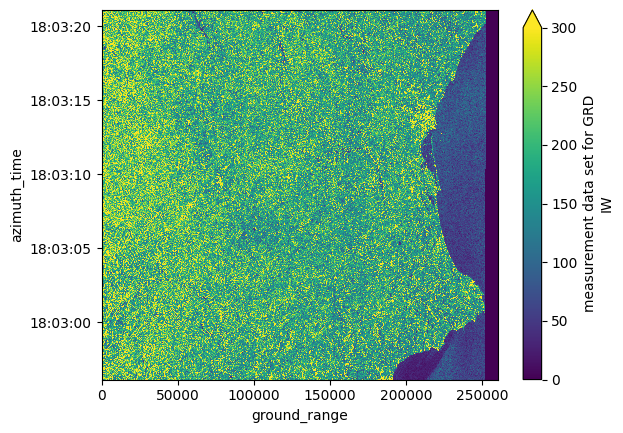

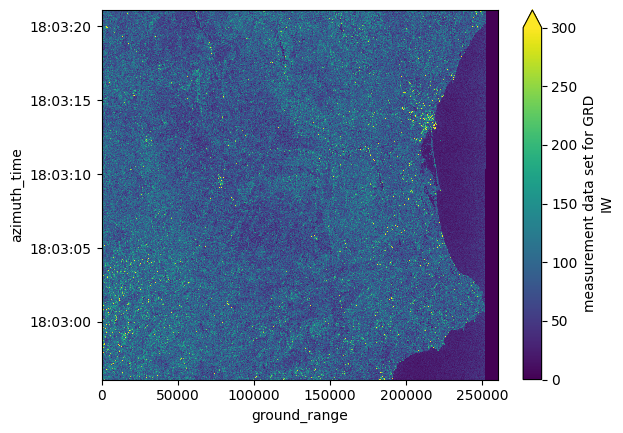

In [18]:
for i in [grd[2], grdVH[2]]:
    #i.plot(vmax=300)
    i.plot(vmax=300)
    plt.show()

In [19]:
# Create calibration list 
i = 0
calibration = []
while i < DATASET_NUMBER:
    calibration.append(datatrees[i][datatrees[i].groups[CALIBRATION_VV_GROUP_ID]].to_dataset())
    i = i + 1

In [20]:
# Create calibration list VH
i = 0
calibrationVH = []
while i < DATASET_NUMBER:
    calibrationVH.append(datatrees[i][datatrees[i].groups[CALIBRATION_VH_GROUP_ID]].to_dataset())
    i = i + 1

In [21]:
# Calibrate intensity for each product
i = 0
intensity = []
while i < DATASET_NUMBER:
    intensity.append(xarray_sentinel.calibrate_intensity(
        grd[i], 
        calibration[i].beta_nought, 
        as_db=True))
    i = i + 1


/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [22]:
# Calibrate intensity for each product VH
i = 0
intensityVH = []
while i < DATASET_NUMBER:
    intensityVH.append(xarray_sentinel.calibrate_intensity(
        grdVH[i], 
        calibrationVH[i].beta_nought, 
        as_db=True))
    i = i + 1


/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/devseed/Documents/repos/eopf-101/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:813: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [23]:
# Calibrate amplitude for each product
i = 0
amplitude = []
while i < DATASET_NUMBER:
    amplitude.append(xarray_sentinel.calibrate_amplitude(
        grd[i], 
        calibration[i].beta_nought))
    i = i + 1

In [24]:
# Calibrate amplitude for each product VH
i = 0
amplitudeVH = []
while i < DATASET_NUMBER:
    amplitudeVH.append(xarray_sentinel.calibrate_amplitude(
        grdVH[i], 
        calibrationVH[i].beta_nought))
    i = i + 1

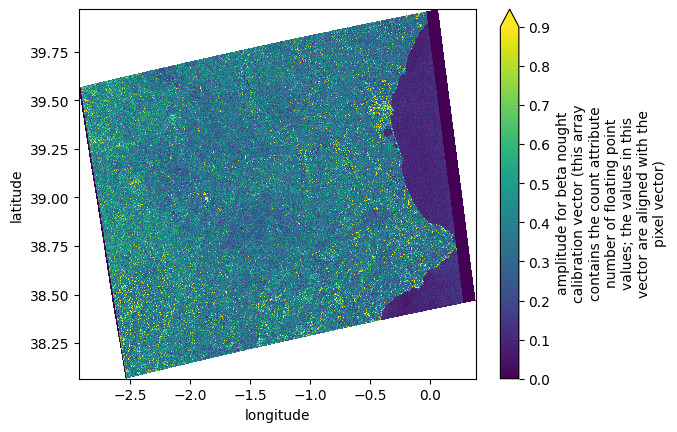

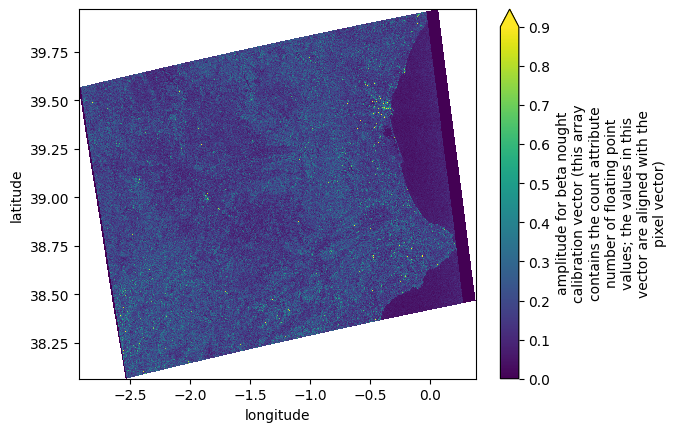

In [26]:
for i in [amplitude[1], amplitudeVH[1]]:
    #i.plot(vmax=300)
    i.plot(x="longitude", y="latitude", vmax=0.9)
    plt.show()

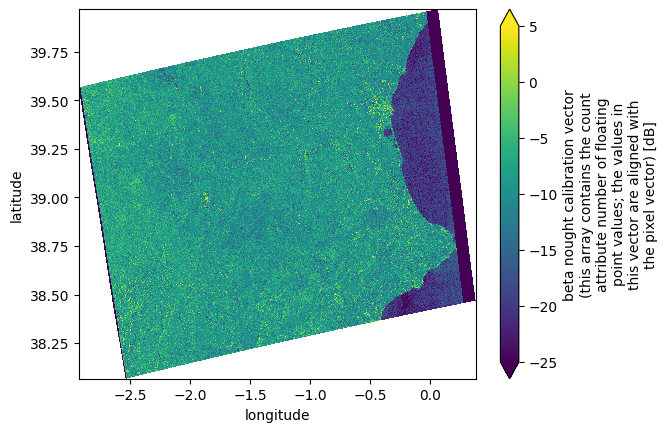

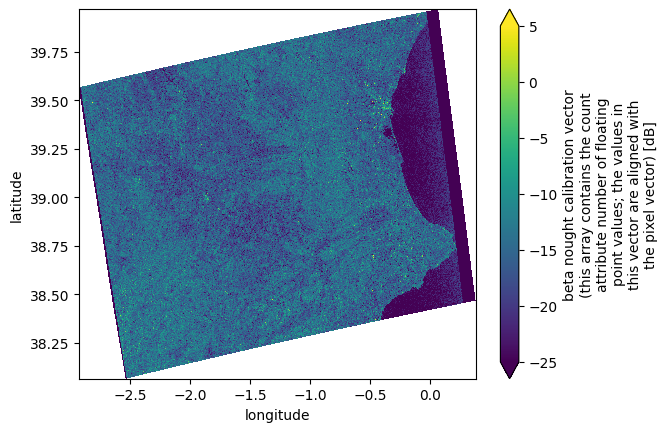

In [27]:
for i in [intensity[1], intensityVH[1]]:
    #i.plot(vmax=300)
    i.plot(x="longitude", y="latitude", vmin=-25, vmax=5)
    plt.show()

In [28]:
i = 0
while i < DATASET_NUMBER:
    print(intensityVH[i].shape)
    i = i + 1
    

(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1304)
(834, 1303)


In [29]:
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [30]:
# ndwi = (amplitude[2] - amplitudeVH[2])/(amplitude[2] + amplitudeVH[2]) # ~ ndwi amplitude
ndwi = (intensity[2] - intensityVH[2])/(intensity[2] + intensityVH[2]) # ~ ndwi intensity
# ndwi = intensity[2]/intensityVH[2] # intensity ratio

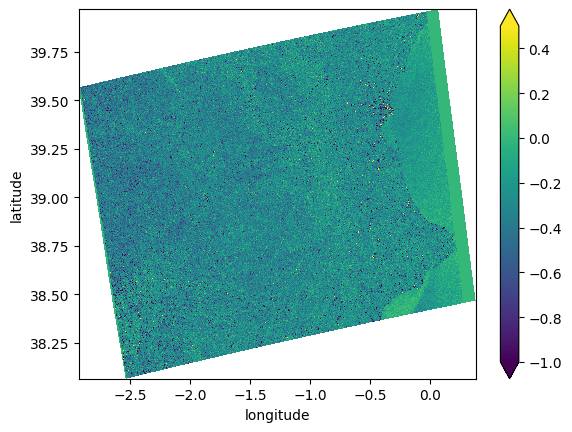

In [31]:
# ndwi.plot(x="longitude", y="latitude", vmin=-1, vmax=2) # amplitude
ndwi.plot(x="longitude", y="latitude", vmin=-1, vmax=0.5) # intensity
# ndwi.plot(x="longitude", y="latitude", vmin=-1, vmax=1) # intensity ratio
plt.show()

In [32]:
# water_mask_after = (intensity[2] <= WATER_THRESHOLD_DB) & (intensity[2] >= OTHER_THRESHOLD_DB)
# water_mask_before = (intensity[1] <= WATER_THRESHOLD_DB) & (intensity[1] >= OTHER_THRESHOLD_DB)

water_mask_after = (intensity[2] <= WATER_THRESHOLD_DB) 
water_mask_before = (intensity[1] <= WATER_THRESHOLD_DB) 

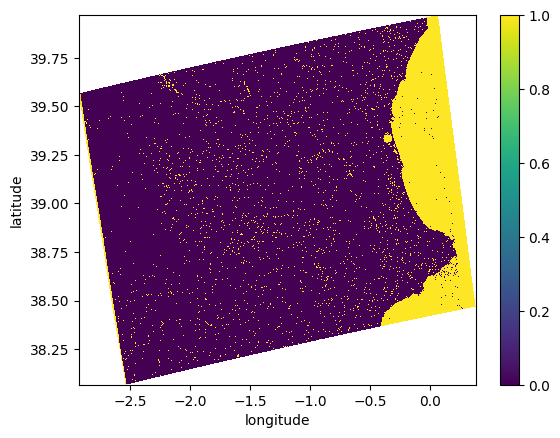

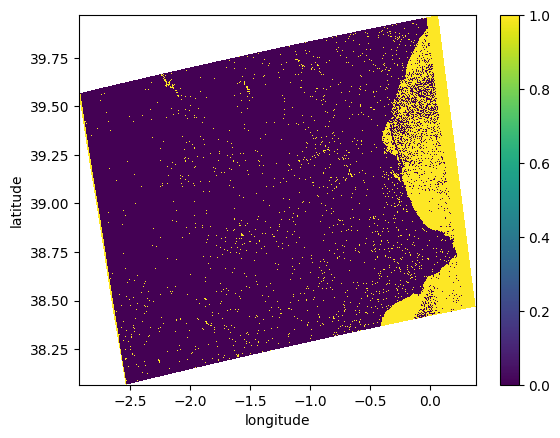

In [33]:
for i in [water_mask_before, water_mask_after]:
    #i.plot(vmax=300)
    i.plot(x="longitude", y="latitude")
    plt.show()

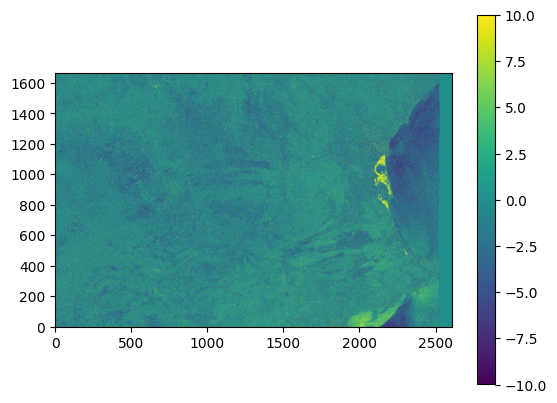

In [34]:
arr = (intensity[1].values-intensity[2].values)  
plt.imshow(arr, vmin=-10, vmax=10)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()


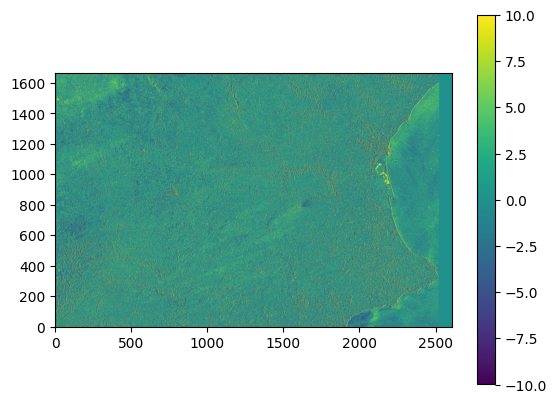

In [36]:
arr2 = (intensity[0].values-intensity[1].values) 
plt.imshow(arr2, vmin=-10, vmax=10)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()


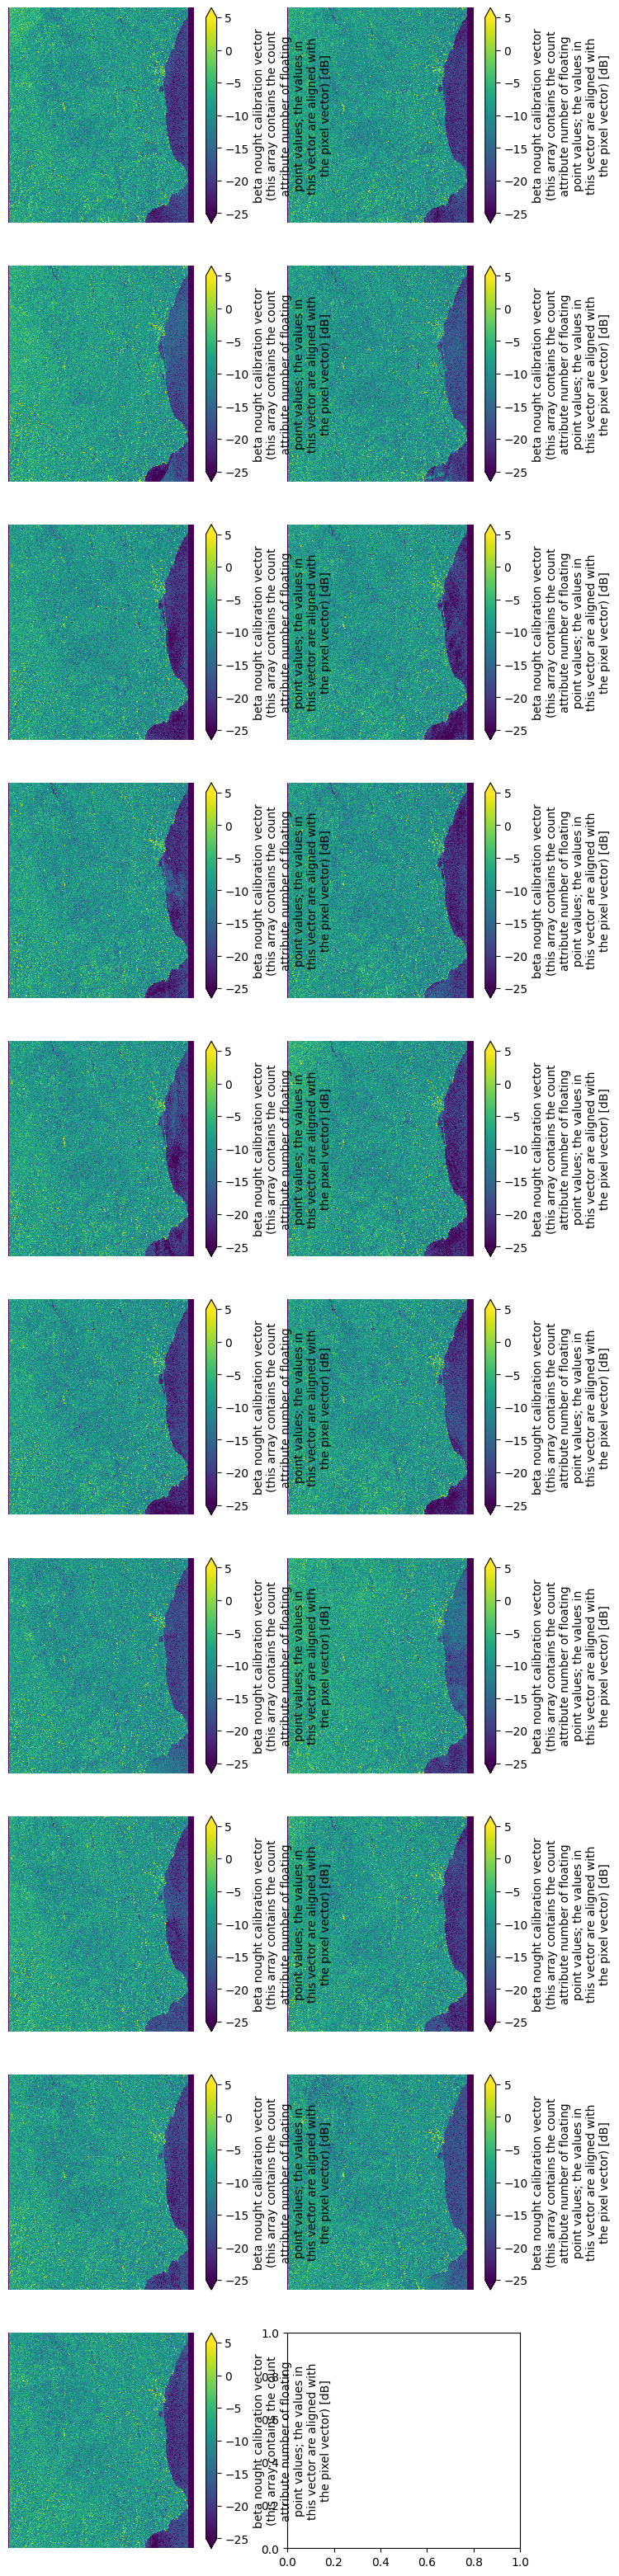

In [37]:
n_images = len(intensity)
n_cols = 2
n_rows = (n_images + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < n_images:
        intensity[i].plot(ax=ax, vmin=-25, vmax=5)
        ax.axis('off')


plt.show()


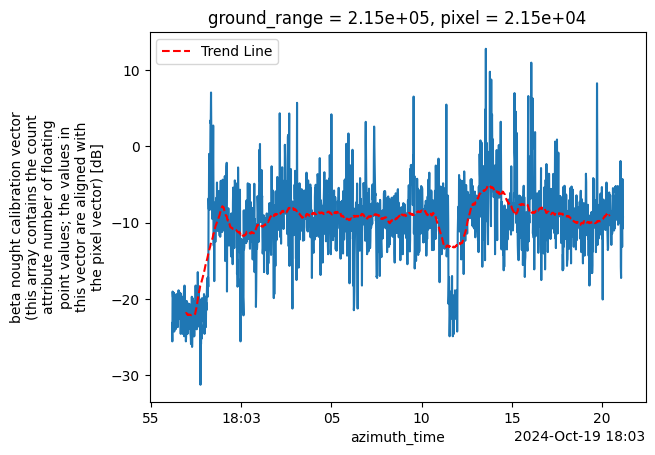

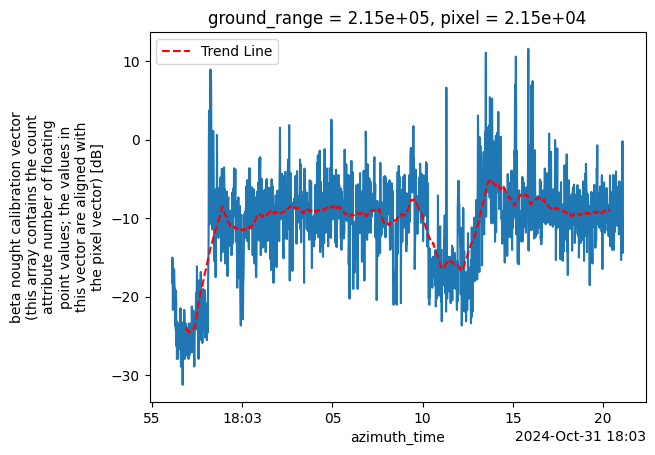

In [38]:

window_size = 100
#this is a flooded area for sure
for i in [intensity[1].sel(ground_range=215000), intensity[2].sel(ground_range=215000)]:
    i.plot()
    x = i[i.dims[0]].values
    y = i.values

    # Use pandas for moving average
    y_smooth = pd.Series(y).rolling(window=window_size, center=True).mean()

    plt.plot(x, y_smooth, color='red', linestyle='--', label='Trend Line')
    plt.legend()
    plt.show()